In [1]:
from dataset import PairedDatasetDouble
pd = PairedDatasetDouble('In/0', 'In/1', 'Out_New', 220)

Length of x_train 0 files: 943
Length of x_train 1 files: 943
Length of y_train files: 943
Item 0 with max: 3482 and min: -2180
Normalized item 0 with max: 1.0 and min: 0.0
Item 1 with max: 1681 and min: -1108
Normalized item 1 with max: 1.0 and min: 0.0
Item 2 with max: 5660 and min: -2212
Normalized item 2 with max: 1.0 and min: 0.0
Item 3 with max: 3564 and min: -1221
Normalized item 3 with max: 1.0 and min: 0.0
Item 4 with max: 3452 and min: -2218
Normalized item 4 with max: 1.0 and min: 0.0
Item 5 with max: 3378 and min: -2213
Normalized item 5 with max: 1.0 and min: 0.0
Item 6 with max: 3744 and min: -2186
Normalized item 6 with max: 1.0 and min: 0.0
Item 7 with max: 3495 and min: -2201
Normalized item 7 with max: 1.0 and min: 0.0
Item 8 with max: 1730 and min: -1078
Normalized item 8 with max: 1.0 and min: 0.0
Item 9 with max: 3420 and min: -1118
Normalized item 9 with max: 1.0 and min: 0.0
Item 10 with max: 3547 and min: -2167
Normalized item 10 with max: 1.0 and min: 0.0
Item 

In [2]:
!conda install -y tensorflow-gpu"=>2.1.0"

Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - conda-forge/noarch::tensorflow-estimator==2.2.0=pyh95af2a2_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - defaults/linux-64::bokeh==1.4.0=py36_0
  - conda-forge/noarch::keras-preprocessing==1.1.0=py_0
  - defaults/linux-64::numpy-base==1.18.1=py36hde5b4d6_1
  - defaults/linux-64::tensorflow==2.2.0=gpu_py36hf933387_0
  - defaults/linux-64::astropy==4.0=py36h7b6447c_0
  - defaults/linux-64::tensorflow-gpu

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

double_model = load_model('dual_model_final.h5')

with open('model_arch.json', 'r') as f:
    single_model = model_from_json(f.read())
    
single_model.load_weights('model_weights.h5')
print("Single and Double AE Models Loaded")

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import numpy.ma as ma

def extract_slice_mask(slice):

    ret, thresh = cv.threshold(slice, 0.1, 1, cv.THRESH_BINARY)
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(thresh.astype('uint8'))

    max = stats[1, 4]
    largest_index = 1

    for k in np.delete(np.unique(labels_im), 0):

        size = stats[k, 4]
        if (size > max):

            max = size
            largest_index = k

    mask = ma.masked_not_equal(labels_im, largest_index)
    return mask

def extract_lung_mask(volume, size = 128):

    slices = []

    for i in range(0, size):

        masked_slice = extract_slice_mask(volume[i])
        slices.append(masked_slice)

    slices = np.array(slices)
    return slices

def tpfp(truth, prediction):

    h, w, l = truth.shape[0], truth.shape[1], truth.shape[2]

    tp = np.zeros(truth.shape)
    fp = np.zeros(truth.shape)
    fn = np.zeros(truth.shape)
    tn = np.zeros(truth.shape)

    truth_mask = extract_lung_mask(truth)
    pred_mask = extract_lung_mask(prediction)

    for i in range(0, h):

        for j in range(0, w):

            for k in range(0, l):

                if (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 1):

                    tp[i, j, k] = 1

                elif (truth_mask[i, j, k] == 1 and pred_mask[i, j, k] == 0):

                    fn[i, j, k] = 1

                elif (truth_mask[i, j, k] == 0 and pred_mask[i, j, k] == 1):

                    fp[i, j, k] = 1

                else:

                    tn[i, j, k] = 1

    tp = ma.masked_values(tp * 100, 0)
    fp = ma.masked_values(fp * 50, 0)
    fn = ma.masked_values(fn, 0)
    
    prdd = pred_mask[64]
    trdd = truth_mask[64]

    return tp, fp, fn


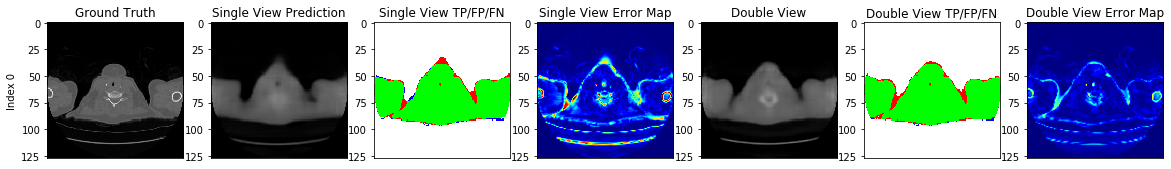

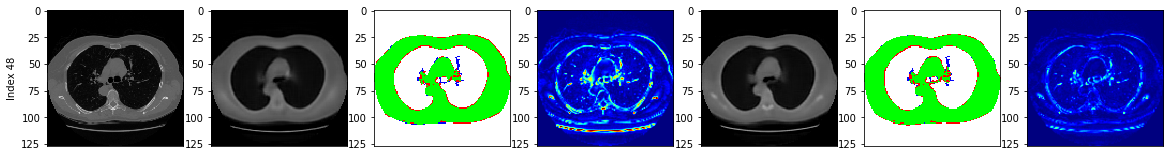

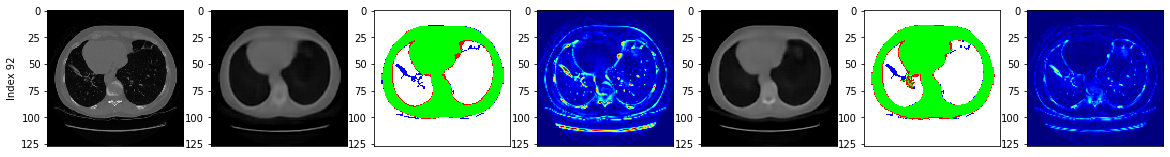

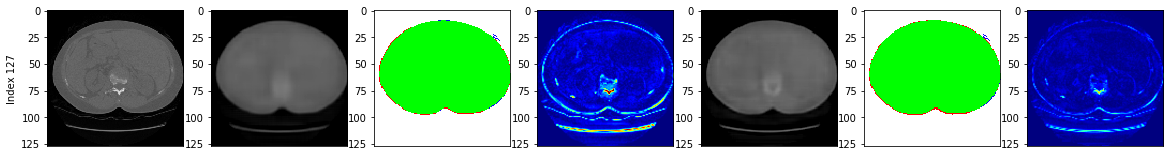

In [18]:
for i in range(1, 2):
    
    input_1 = pd.x_train_0[i]
    input_2 = pd.x_train_1[i]
    
    input_1 = np.reshape(input_1, (1, 1024, 1024, 1))
    input_2 = np.reshape(input_2, (1, 1024, 1024, 1))
    
    output_single = single_model.predict(input_1)
    output_double = double_model.predict([input_1, input_2])
    
    output_single = np.reshape(output_single, (128, 128, 128))
    output_double = np.reshape(output_double, (128, 128, 128))
    
    original = pd.y_train[i]
    
    s_tp, s_fp, s_fn = tpfp(original, output_single)
    d_tp, d_fp, d_fn = tpfp(original, output_double)
    
    slice_depths = [0, 48, 92, 127]
    
    for k in slice_depths:
    
        f = plt.figure(figsize = (20, 12))

        f.add_subplot(1, 7, 1)
        plt.imshow(original[k], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
        plt.ylabel('Index ' + str(k))
        plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)

        if (k == 0):
            
            plt.title('Ground Truth')
        f.add_subplot(1, 7, 2)
        plt.imshow(output_single[k], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
        plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)

        if (k == 0):
            
            plt.title('Single View Prediction')
        f.add_subplot(1, 7, 3)
        plt.imshow(s_tp[k], cmap = 'brg', vmin = 0.1, interpolation = 'none')
        plt.imshow(s_fp[k], cmap = 'brg', vmin = 0.1, vmax = 100, interpolation = 'none')
        plt.imshow(s_fn[k], cmap = 'brg', vmin = 0.1, vmax = 90, interpolation = 'none')
        plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)

        if (k == 0):
            
            plt.title('Single View TP/FP/FN')
            
            
        f.add_subplot(1, 7, 4)
        error_map_single = np.abs(original - output_single)
        error_map_single = error_map_single
        plt.imshow(error_map_single[k], cmap = 'jet', vmin = 0, vmax = 0.3, interpolation = 'gaussian')
        plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)

        if (k == 0):
            
            plt.title('Single View Error Map')
            
            
        f.add_subplot(1, 7, 5)
        plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)

        plt.imshow(output_double[k], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
        if (k == 0):
            
            plt.title('Double View')
        f.add_subplot(1, 7, 6)
        plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)

        plt.imshow(d_tp[k], cmap = 'brg', vmin = 0.1, interpolation = 'none')
        plt.imshow(d_fp[k], cmap = 'brg', vmin = 0.1, vmax = 100, interpolation = 'none')
        plt.imshow(d_fn[k], cmap = 'brg', vmin = 0.1, vmax = 90, interpolation = 'none')   
        if (k == 0):
            
            plt.title('Double View TP/FP/FN')
            
        f.add_subplot(1, 7, 7)
        plt.tick_params(
        axis='both',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False)

        error_map_double = np.abs(original - output_double)
        error_map_double = error_map_double
        plt.imshow(error_map_double[k], cmap = 'jet', vmin = 0, vmax = 0.5, interpolation = 'gaussian')
        if (k == 0):
            
            plt.title('Double View Error Map')
        
        plt.savefig('Figures/EM{}'.format(str(k)))
        plt.show()

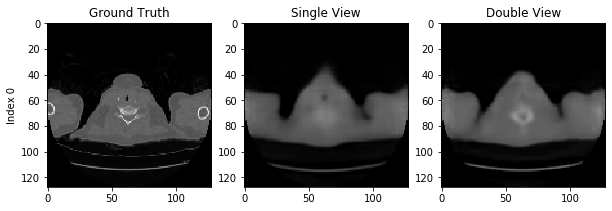

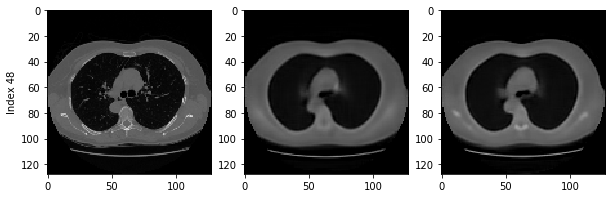

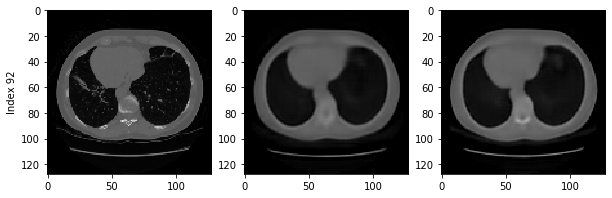

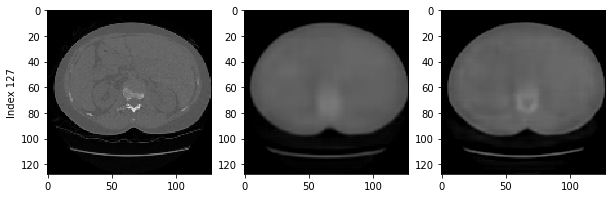

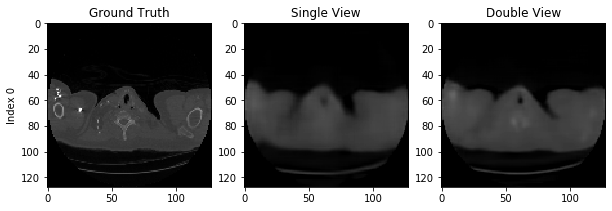

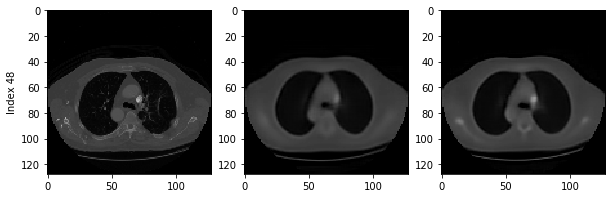

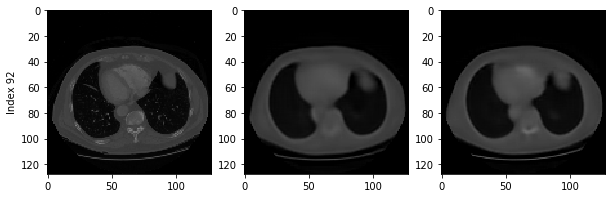

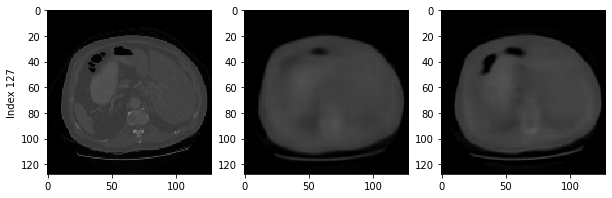

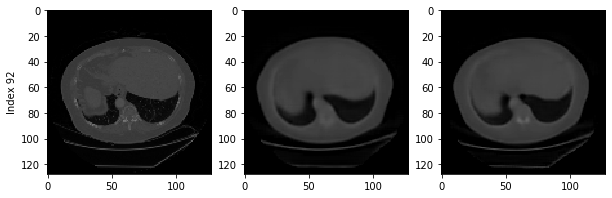

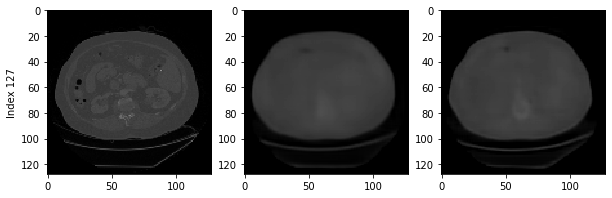

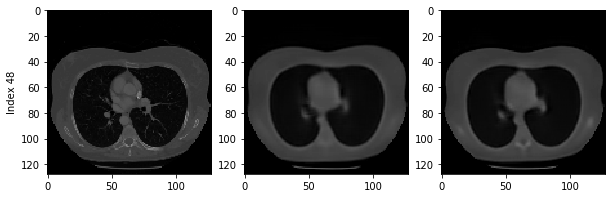

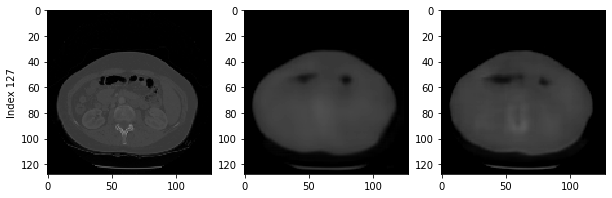

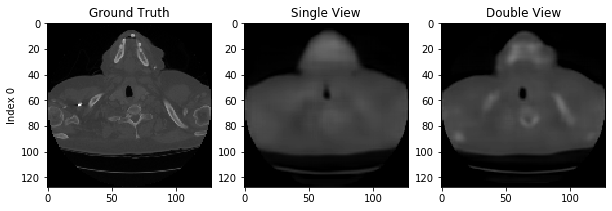

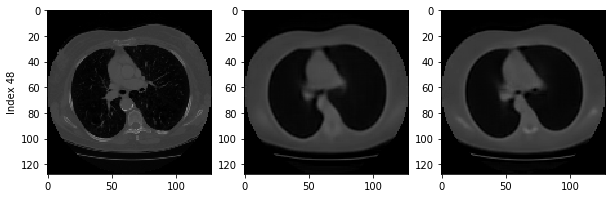

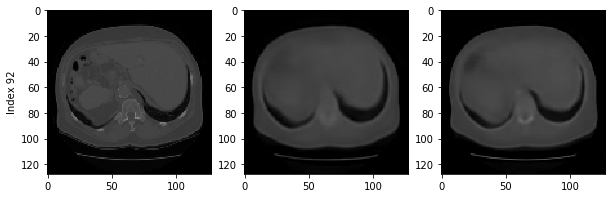

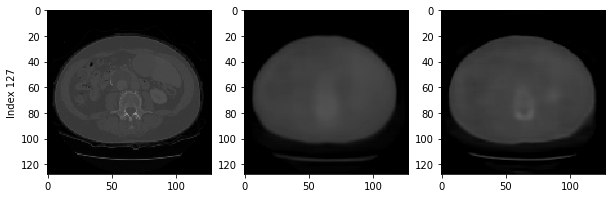

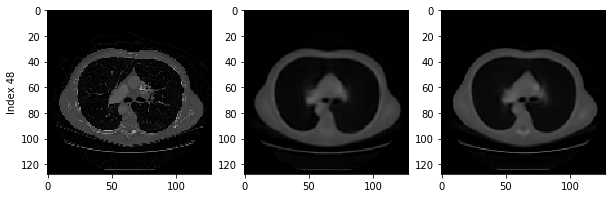

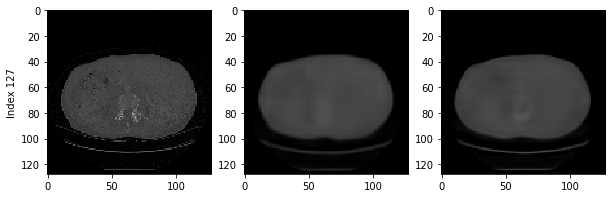

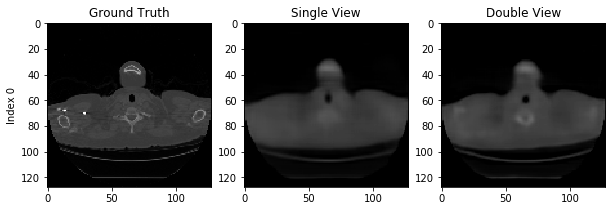

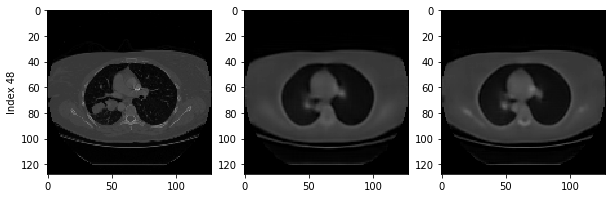

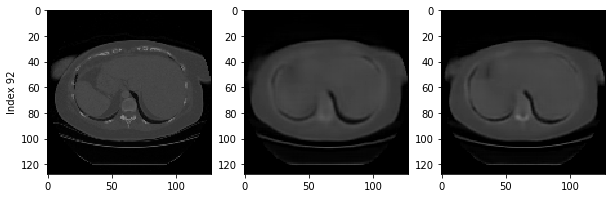

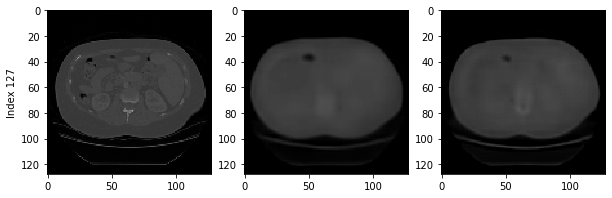

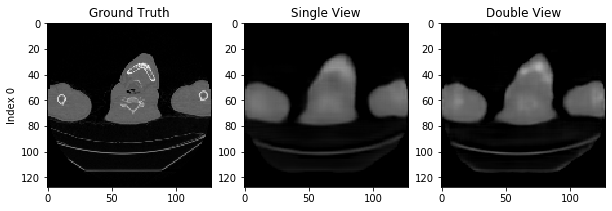

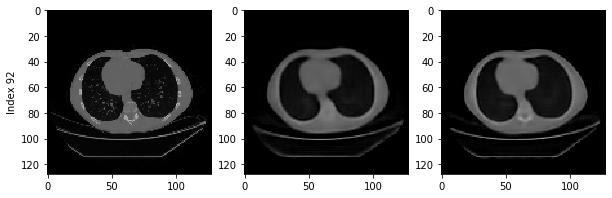

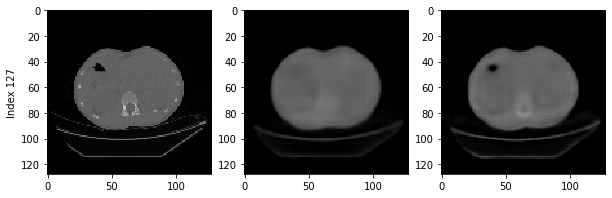

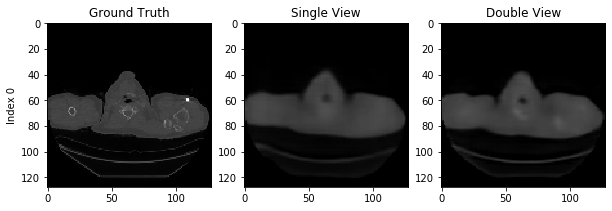

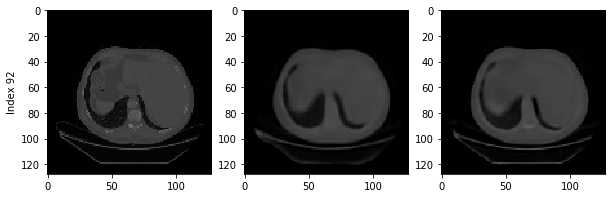

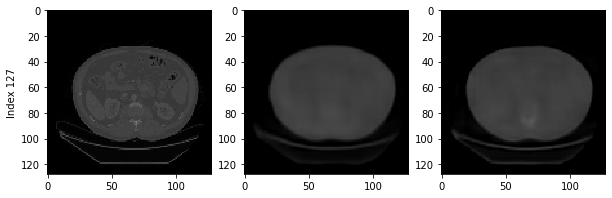

In [19]:
for i in range(1, 10):
    
    input_1 = pd.x_train_0[i]
    input_2 = pd.x_train_1[i]
    
    input_1 = np.reshape(input_1, (1, 1024, 1024, 1))
    input_2 = np.reshape(input_2, (1, 1024, 1024, 1))
    
    output_single = single_model.predict(input_1)
    output_double = double_model.predict([input_1, input_2])
    
    output_single = np.reshape(output_single, (128, 128, 128))
    output_double = np.reshape(output_double, (128, 128, 128))
    
    original = pd.y_train[i]
    
    
    slice_depths = [0, 48, 92, 127]
    
    for k in slice_depths:
    
        f = plt.figure(figsize = (10, 7))

        f.add_subplot(1, 3, 1)
        plt.imshow(original[k], cmap = 'gray', vmin = 0, vmax = 1)
        plt.ylabel("Index " + str(k))
        if (k == 0):
            
            plt.title('Ground Truth')

        f.add_subplot(1, 3, 2)
        plt.imshow(output_single[k], cmap = 'gray', vmin = 0, vmax = 1)
        if (k == 0):
            
            plt.title('Single View')

        f.add_subplot(1, 3, 3)
        plt.imshow(output_double[k], cmap = 'gray', vmin = 0, vmax = 1)
        if (k == 0):
            
            plt.title('Double View')

        plt.show()

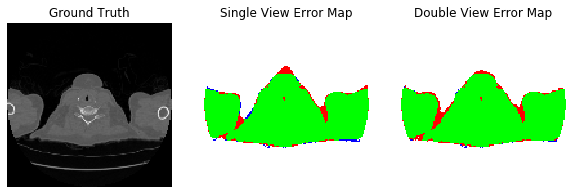

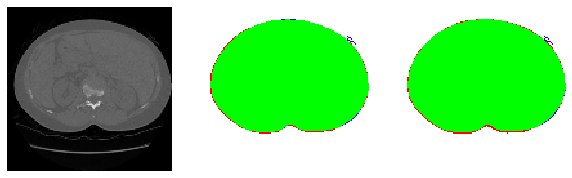

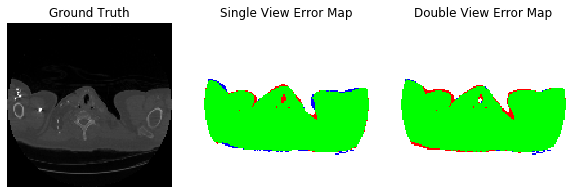

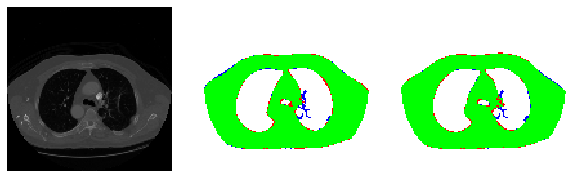

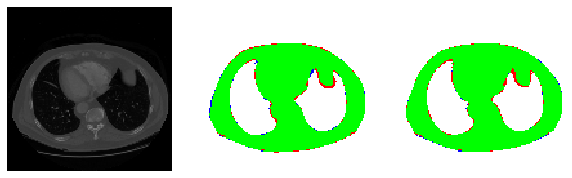

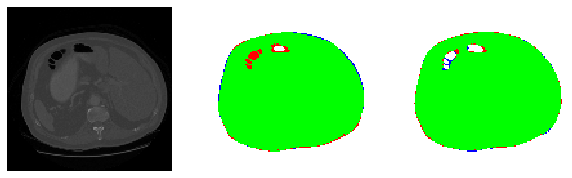

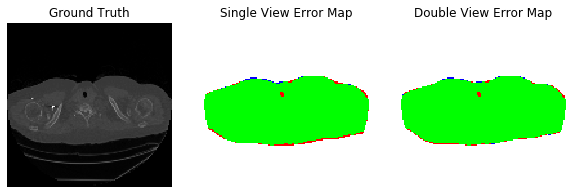

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
<string>:6: UserWarning: Warning: converting a masked element to nan.
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


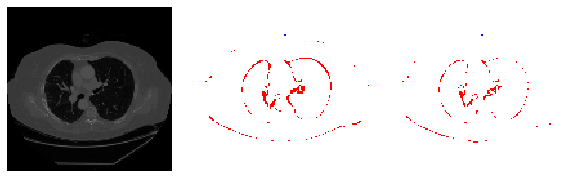

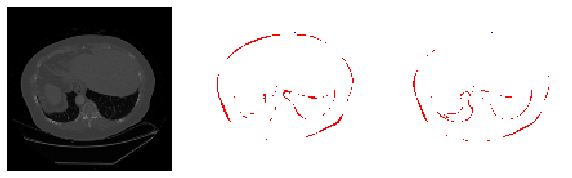

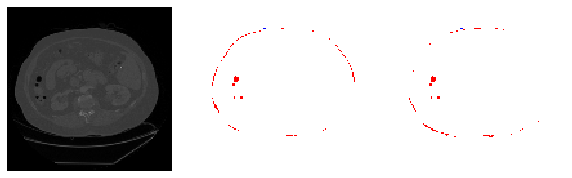

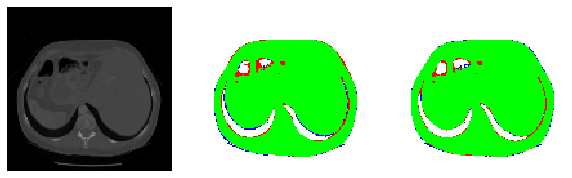

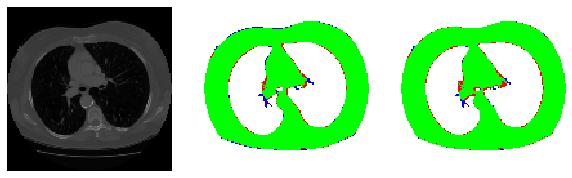

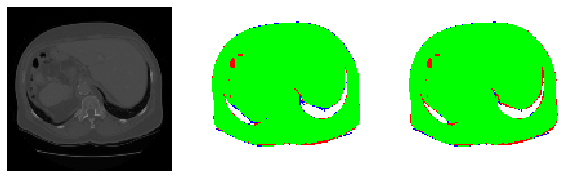

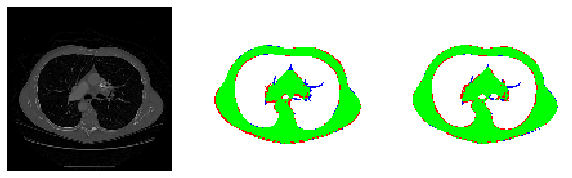

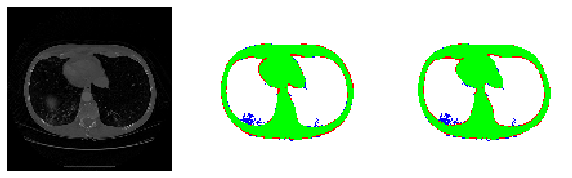

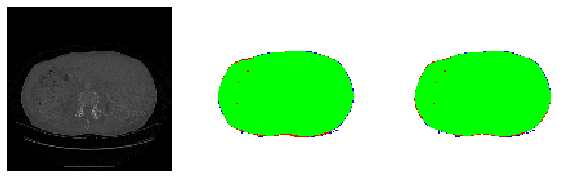

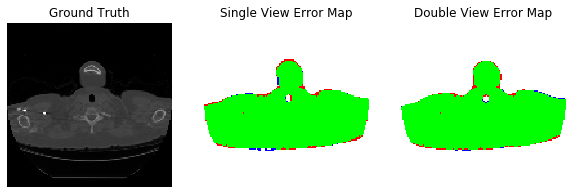

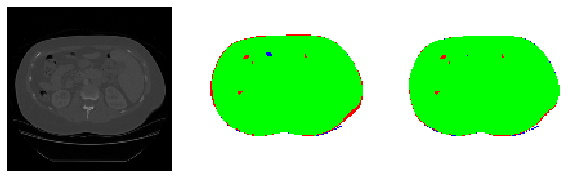

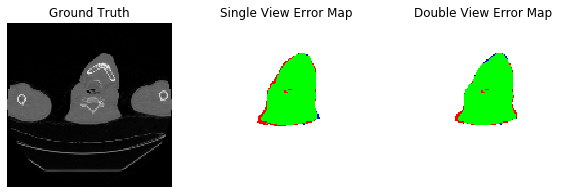

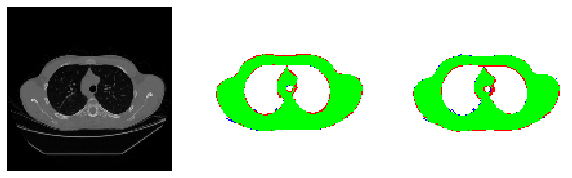

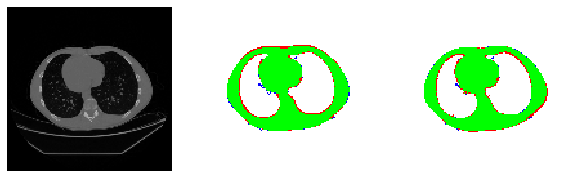

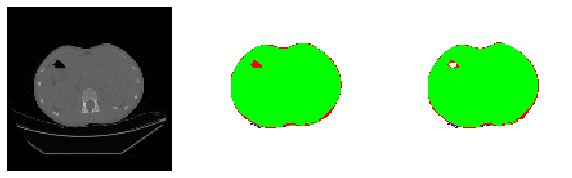

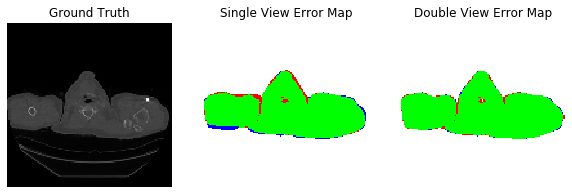

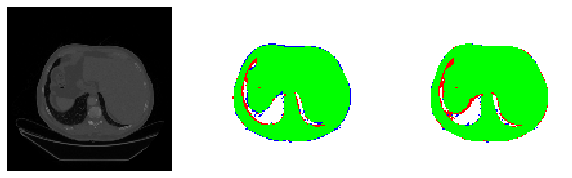

In [7]:
for i in range(1, 10):
    
    input_1 = pd.x_train_0[i]
    input_2 = pd.x_train_1[i]
    
    input_1 = np.reshape(input_1, (1, 1024, 1024, 1))
    input_2 = np.reshape(input_2, (1, 1024, 1024, 1))
    
    output_single = single_model.predict(input_1)
    output_double = double_model.predict([input_1, input_2])
    
    output_single = np.reshape(output_single, (128, 128, 128))
    output_double = np.reshape(output_double, (128, 128, 128))
    
    original = pd.y_train[i]
    
    s_tp, s_fp, s_fn = tpfp(original, output_single)
    d_tp, d_fp, d_fn = tpfp(original, output_double)
    
    slice_depths = [0, 48, 92, 127]
    
    for k in slice_depths:
    
        f = plt.figure(figsize = (10, 7))

        f.add_subplot(1, 3, 1)
        plt.imshow(original[k], cmap = 'gray', vmin = 0, vmax = 1)
        plt.axis('off')
        plt.ylabel("Index " + str(k))
        if (k == 0):
            
            plt.title('Ground Truth')

        f.add_subplot(1, 3, 2)
        plt.imshow(s_tp[k], cmap = 'brg', vmin = 0.1)
        plt.imshow(s_fp[k], cmap = 'brg', vmin = 0.1, vmax = 100)
        plt.imshow(s_fn[k], cmap = 'brg', vmin = 0.1, vmax = 90)
        plt.axis('off')
        if (k == 0):
            
            plt.title('Single View Error Map')
        f.add_subplot(1, 3, 3)
        plt.imshow(d_tp[k], cmap = 'brg', vmin = 0.1)
        plt.imshow(d_fp[k], cmap = 'brg', vmin = 0.1, vmax = 100)
        plt.imshow(d_fn[k], cmap = 'brg', vmin = 0.1, vmax = 90)  
        plt.axis('off')
        if (k == 0):
            
            plt.title('Double View Error Map')
        plt.show()

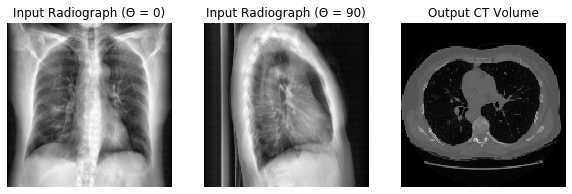

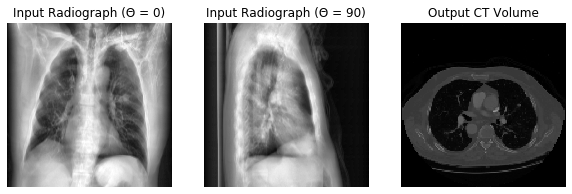

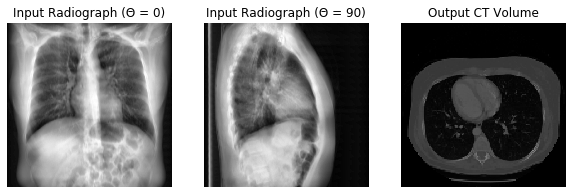

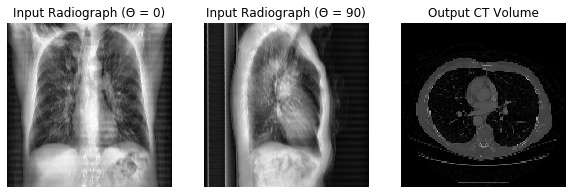

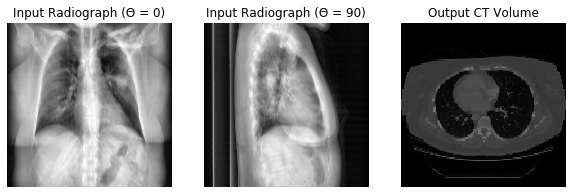

In [8]:
for i in range(0, 10):
    
    input_1 = pd.x_train_0[i]
    input_2 = pd.x_train_1[i]
    output = pd.y_train[i]
    
    f = plt.figure(figsize = (10, 7))
    f.add_subplot(1, 3, 1)
    plt.imshow(input_1, cmap = 'gray')
    plt.title("Input Radiograph (Θ = 0)")
    plt.axis('off')

    f.add_subplot(1, 3, 2)
    plt.imshow(input_2, cmap = 'gray')
    plt.title("Input Radiograph (Θ = 90)")
    plt.axis('off')
    f.add_subplot(1, 3, 3)
    plt.imshow(output[64], cmap = 'gray', vmin = 0, vmax = 1)
    plt.title("Output CT Volume")
    plt.axis('off')
    plt.show()

In [9]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy.ma as ma
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology

def dice_score(im1, im2, empty_score=1.0):

    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

def plot_3d(image): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

def extract_slice_mask(slice):

    ret, thresh = cv.threshold(slice, 0.1, 1, cv.THRESH_BINARY)
    num_labels, labels_im, stats, centroids = cv.connectedComponentsWithStats(thresh.astype('uint8'))

    max = stats[1, 4]
    largest_index = 1

    for k in np.delete(np.unique(labels_im), 0):

        size = stats[k, 4]
        if (size > max):

            max = size
            largest_index = k

    mask = ma.masked_not_equal(labels_im, largest_index)
    return mask


def contour_image(scan):
    
    contour_slices = []
    
    for i in range(0, 127):

        tslice = scan[i]

        thresh = extract_slice_mask(tslice).filled(0)

        contours, hierarchy = cv.findContours(thresh.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)


        if len(contours) != 0:
            temp = cv.fillPoly(tslice, pts = np.array(contours[0]), color = (255, 255, 255))
            contour_slices.append(temp)

    contour_slices = np.array(contour_slices)
    return contour_slices
    
    
def water_diameter_plot(scan):
    
    contour_slices = []
    
    for i in range(0, 127):

        tslice = scan[i]

        thresh = extract_slice_mask(tslice).filled(0)

        contours, hierarchy = cv.findContours(thresh.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)


        if len(contours) != 0:
            temp = cv.fillPoly(tslice, pts = np.array(contours[0]), color = (255, 255, 255))
            contour_slices.append(temp)


    contour_slices = np.array(contour_slices)
    plot_3d(contour_slices)
    
def create_mesh(img):
    
    verts, faces, normals, values = measure.marching_cubes_lewiner(img)
    mesh = Poly3DCollection(verts[faces], alpha = 0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    return mesh

for i in range(0, 1):
    
    input_1 = pd.x_train_0[i]
    input_2 = pd.x_train_1[i]
    
    input_1 = np.reshape(input_1, (1, 1024, 1024, 1))
    input_2 = np.reshape(input_2, (1, 1024, 1024, 1))
    
    expected = pd.y_train[i]
    expected_contour = contour_image(expected)
    predicted_single = single_model.predict(input_1)
    predicted_double = double_model.predict([input_1, input_2])
    predicted_single = np.reshape(predicted_single, (128, 128, 128))
    predicted_single_contour = contour_image(predicted_single)
    predicted_double = np.reshape(predicted_double, (128, 128, 128))
    predicted_double_contour = contour_image(predicted_double)
    
    
    #expected
    p_ex = expected_contour.transpose(2, 1, 0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p_ex)
    f = plt.figure(figsize = (27, 9))
    ax = f.add_subplot(1, 3, 1, projection = '3d')
    mesh = Poly3DCollection(verts[faces], alpha = 0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    del verts, faces, normals, values, mesh
    ax.set_xlim(0, p_ex.shape[0])
    ax.set_ylim(0, p_ex.shape[1])
    ax.set_zlim(0, p_ex.shape[2])
    #ax.set_title("True Effective Diameter")
    
    #single - output
    p_single = predicted_single_contour.transpose(2, 1, 0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p_single)
    ax1 = f.add_subplot(1, 3, 2, projection = '3d')
    mesh = Poly3DCollection(verts[faces], alpha = 0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax1.add_collection3d(mesh)
    del verts, faces, normals, values, mesh
    ax1.set_xlim(0, p_ex.shape[0])
    ax1.set_ylim(0, p_ex.shape[1])
    ax1.set_zlim(0, p_ex.shape[2])
    #ax1.set_title("Single View Predicted Effective Diameter")
    
    #double - output
    p_double = predicted_double_contour.transpose(2, 1, 0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p_double)
    ax2 = f.add_subplot(1, 3, 3, projection = '3d')
    mesh = Poly3DCollection(verts[faces], alpha = 0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax2.add_collection3d(mesh)
    del verts, faces, normals, values, mesh
    ax2.set_xlim(0, p_ex.shape[0])
    ax2.set_ylim(0, p_ex.shape[1])
    ax2.set_zlim(0, p_ex.shape[2])
    #ax2.set_title("Double View Predicted Effective Diameter")
    plt.savefig('Figures/mesh.png')
    plt.show()
    
    #water_diameter_plot(expected)
    #water_diameter_plot(predicted_single)
    #water_diameter_plot(predicted_double)
    print("Single accuracy: {}".format(str(dice_score(contour_image(expected), contour_image(predicted_single)))))
    print("Double accuracy: {}".format(str(dice_score(contour_image(expected), contour_image(predicted_double)))))


Single accuracy: 0.8893488828675483
Double accuracy: 0.8952036686402788


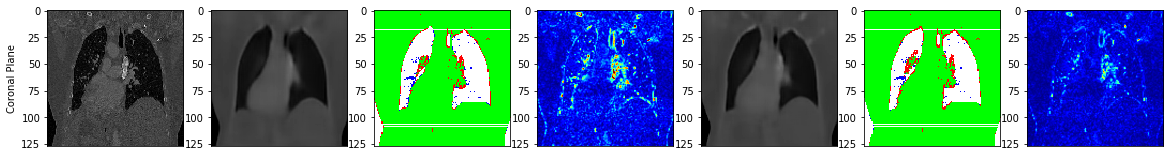

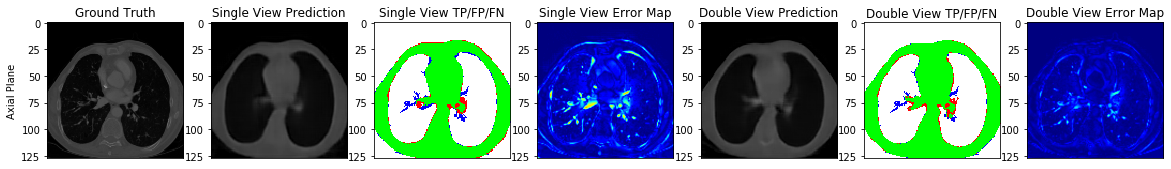

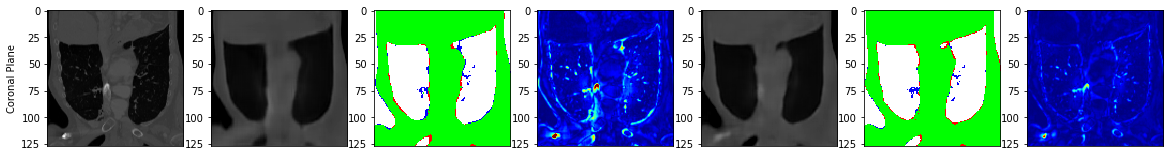

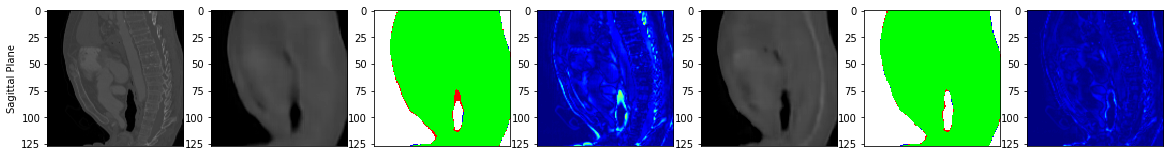

In [20]:
for i in range(120, 122):
    
    input_1 = pd.x_train_0[i]
    input_2 = pd.x_train_1[i]
    
    input_1 = np.reshape(input_1, (1, 1024, 1024, 1))
    input_2 = np.reshape(input_2, (1, 1024, 1024, 1))
    
    output_single = single_model.predict(input_1)
    output_double = double_model.predict([input_1, input_2])
    
    output_single = np.reshape(output_single, (128, 128, 128))
    output_double = np.reshape(output_double, (128, 128, 128))
    
    original = pd.y_train[i]
    
    s_tp, s_fp, s_fn = tpfp(original, output_single)
    d_tp, d_fp, d_fn = tpfp(original, output_double)
    
    slice_depths = [0, 48, 92, 127]
    
    for k in range(0, 3):
        
        if (k == 0):
            
            

            f = plt.figure(figsize = (20, 12))

            f.add_subplot(1, 7, 1)
            plt.imshow(original[64], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
            plt.ylabel('Axial Plane')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Ground Truth')
            f.add_subplot(1, 7, 2)
            plt.imshow(output_single[64], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Single View Prediction')
            f.add_subplot(1, 7, 3)
            plt.imshow(s_tp[64], cmap = 'brg', vmin = 0.1, interpolation = 'none')
            plt.imshow(s_fp[64], cmap = 'brg', vmin = 0.1, vmax = 100, interpolation = 'none')
            plt.imshow(s_fn[64], cmap = 'brg', vmin = 0.1, vmax = 90, interpolation = 'none')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Single View TP/FP/FN')


            f.add_subplot(1, 7, 4)
            error_map_single = np.abs(original - output_single)
            error_map_single = error_map_single
            plt.imshow(error_map_single[64], cmap = 'jet', vmin = 0, vmax = 0.3, interpolation = 'gaussian')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Single View Error Map')


            f.add_subplot(1, 7, 5)
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            plt.imshow(output_double[64], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
            if (k == 0):

                plt.title('Double View Prediction')
            f.add_subplot(1, 7, 6)
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            plt.imshow(d_tp[64], cmap = 'brg', vmin = 0.1, interpolation = 'none')
            plt.imshow(d_fp[64], cmap = 'brg', vmin = 0.1, vmax = 100, interpolation = 'none')
            plt.imshow(d_fn[64], cmap = 'brg', vmin = 0.1, vmax = 90, interpolation = 'none')   
            if (k == 0):

                plt.title('Double View TP/FP/FN')

            f.add_subplot(1, 7, 7)
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            error_map_double = np.abs(original - output_double)
            error_map_double = error_map_double
            plt.imshow(error_map_double[64], cmap = 'jet', vmin = 0, vmax = 0.5, interpolation = 'gaussian')
            if (k == 0):

                plt.title('Double View Error Map')

            plt.savefig('Figures/EM{}'.format(str(k)))
            plt.show()
            
        if (k == 1):
            
            

            f = plt.figure(figsize = (20, 12))

            f.add_subplot(1, 7, 1)
            plt.imshow(original[:, 64], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
            plt.ylabel('Coronal Plane')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Ground Truth')
            f.add_subplot(1, 7, 2)
            plt.imshow(output_single[:, 64], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Single View Prediction')
            f.add_subplot(1, 7, 3)
            plt.imshow(s_tp[:, 64], cmap = 'brg', vmin = 0.1, interpolation = 'none')
            plt.imshow(s_fp[:, 64], cmap = 'brg', vmin = 0.1, vmax = 100, interpolation = 'none')
            plt.imshow(s_fn[:, 64], cmap = 'brg', vmin = 0.1, vmax = 90, interpolation = 'none')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Single View TP/FP/FN')


            f.add_subplot(1, 7, 4)
            error_map_single = np.abs(original - output_single)
            error_map_single = error_map_single
            plt.imshow(error_map_single[:, 64], cmap = 'jet', vmin = 0, vmax = 0.3, interpolation = 'gaussian')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Single View Error Map')


            f.add_subplot(1, 7, 5)
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            plt.imshow(output_double[:, 64], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
            if (k == 0):

                plt.title('Double View Prediction')
            f.add_subplot(1, 7, 6)
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            plt.imshow(d_tp[:, 64], cmap = 'brg', vmin = 0.1, interpolation = 'none')
            plt.imshow(d_fp[:, 64], cmap = 'brg', vmin = 0.1, vmax = 100, interpolation = 'none')
            plt.imshow(d_fn[:, 64], cmap = 'brg', vmin = 0.1, vmax = 90, interpolation = 'none')   
            if (k == 0):

                plt.title('Double View TP/FP/FN')

            f.add_subplot(1, 7, 7)
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            error_map_double = np.abs(original - output_double)
            error_map_double = error_map_double
            plt.imshow(error_map_double[:, 64], cmap = 'jet', vmin = 0, vmax = 0.5, interpolation = 'gaussian')
            if (k == 0):

                plt.title('Double View Error Map')

            plt.savefig('Figures/EM{}'.format(str(k)))
            plt.show()
            
        if (k == 2):
            
            

            f = plt.figure(figsize = (20, 12))

            f.add_subplot(1, 7, 1)
            plt.imshow(original[:, :, 64], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
            plt.ylabel('Sagittal Plane')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Ground Truth')
            f.add_subplot(1, 7, 2)
            plt.imshow(output_single[:, :, 64], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Single View Prediction')
            f.add_subplot(1, 7, 3)
            plt.imshow(s_tp[:, :, 64], cmap = 'brg', vmin = 0.1, interpolation = 'none')
            plt.imshow(s_fp[:, :, 64], cmap = 'brg', vmin = 0.1, vmax = 100, interpolation = 'none')
            plt.imshow(s_fn[:, :, 64], cmap = 'brg', vmin = 0.1, vmax = 90, interpolation = 'none')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Single View TP/FP/FN')


            f.add_subplot(1, 7, 4)
            error_map_single = np.abs(original - output_single)
            error_map_single = error_map_single
            plt.imshow(error_map_single[:, :, 64], cmap = 'jet', vmin = 0, vmax = 0.3, interpolation = 'gaussian')
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            if (k == 0):

                plt.title('Single View Error Map')


            f.add_subplot(1, 7, 5)
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            plt.imshow(output_double[:, :, 64], cmap = 'gray', vmin = 0, vmax = 1, interpolation = 'none')
            if (k == 0):

                plt.title('Double View Prediction')
            f.add_subplot(1, 7, 6)
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            plt.imshow(d_tp[:, :, 64], cmap = 'brg', vmin = 0.1, interpolation = 'none')
            plt.imshow(d_fp[:, :, 64], cmap = 'brg', vmin = 0.1, vmax = 100, interpolation = 'none')
            plt.imshow(d_fn[:, :, 64], cmap = 'brg', vmin = 0.1, vmax = 90, interpolation = 'none')   
            if (k == 0):

                plt.title('Double View TP/FP/FN')

            f.add_subplot(1, 7, 7)
            plt.tick_params(
            axis='both',          
            which='both',      
            bottom=False,      
            top=False,         
            labelbottom=False)

            error_map_double = np.abs(original - output_double)
            error_map_double = error_map_double
            plt.imshow(error_map_double[:, :, 64], cmap = 'jet', vmin = 0, vmax = 0.5, interpolation = 'gaussian')
            if (k == 0):

                plt.title('Double View Error Map')

            plt.savefig('Figures/EM{}'.format(str(k)))
            plt.show()

In [ ]:
import numpy.ma as ma

def get_points(slice, value):
    
    points = []
    
    for i in range(0, slice.shape[0]):
        
        for j in range(0, slice.shape[1]):
            
            if slice[i, j] == value:
                
                points.append((i, j))
                
    return points

def find_points_by_y(points, y):
    
    true_points = []
    
    for point in points:
        
        if point[0] == y:
            
            true_points.append(point)
            
    return true_points

def get_boundaries(contour_array):
    
    left_side = []
    right_side = []
    
    for i in range(0, 127):
        
        temp_sl = predicted_double_contour[i]
        points = get_points(temp_sl, 255)
        y_pts = find_points_by_y(points, 66)
        if len(y_pts) == 2:
            pt1 = y_pts[0]
            pt2 = y_pts[1]
        left_side.append(pt1)
        right_side.append(pt2)
        
    return left_side, right_side

volumetric = pd.y_train[1][:, 55]
outline_array = np.zeros(volumetric.shape)
left, right = get_boundaries(expected_contour)
print(left)
for pt in left:
    
    outline_array[pt[0], pt[1]] -= 1000
    
for pt in right: 
    
    outline_array[pt[0], pt[1]] -= 1000



In [84]:
print(right)

[(66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 127), (66, 126), (66, 126), (66, 126), (66, 125), (66, 125), (66, 125), (66, 124), (66, 124), (66, 124), (66, 124), (66, 123), (66, 123), (66, 123), (66, 123), (66, 123), (66, 122), (66, 122), (66, 122), (66, 122), (66, 122), (66, 121), (66, 121), (66, 121), (66, 121), (66, 121), (66, 120), (66, 120), (66, 119), (66, 119), (66, 119), (66, 118), (66, 118), (66, 118), (66, 117), (66, 117), (66, 117), (66, 117), (66, 116), (66, 116), (66, 116), (66, 116), (66, 116), (66, 116), (66, 116), (66, 116), (66, 116), (66, 116), (66, 115), (66, 115), (66, 115)

In [85]:
right = np.array(right)

TypeError: list indices must be integers or slices, not tuple

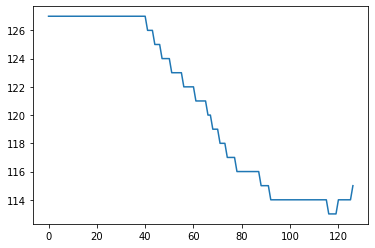

In [87]:
plt.plot(right[:, 1])
plt.plot(left[:, 1])
plt.show()